# ANN, excluding Cys-epitopes

In [1]:
import json
import os
from copy import deepcopy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

2025-01-15 10:08:13.443430: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-15 10:08:13.451106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736953693.459708   98349 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736953693.462258   98349 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-15 10:08:13.471252: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## dataset

In [2]:
infile = '/home/yuan/results/epitope/epi_top_features.txt'
df = pd.read_csv(infile, sep='\t', header=0, index_col=None)
# balance the number of epitopes and non-epitopes
# shuffle rows
df = df.sample(frac=1)
df.head()

,seq,label,mean_hydro_ph7,mean_hydro,mean_polar,mean_polar_stab,mean_VDWV,median_hydro_ph7,median_hydro,median_polar,...,has_C,has_I,has_L,has_K,has_F,has_P,has_S,has_T,has_Y,has_V
1477002,EPWLSSKPEF,1,10.700000,1.229000,8.580000,0.179200,3.894000,-14.0,1.34,8.6,...,0,0,1,1,1,1,1,0,0,0
398521,VSVQQVQKTQSGLES,1,15.266667,0.492000,8.893333,0.132667,2.983333,-5.0,0.05,9.2,...,0,0,1,1,0,0,1,1,0,1
1939356,YANAISWVANAVPTA,0,34.800000,0.974000,7.873333,0.131467,2.824667,41.0,0.61,8.1,...,0,1,0,0,0,1,1,1,1,1
1127335,LPPGAMAAVGL,0,34.090909,1.039091,7.245455,0.103000,2.170000,41.0,1.18,8.0,...,0,0,1,0,0,1,0,0,0,1
3409706,PTCFILCGN,0,37.000000,1.115556,7.055556,0.143444,3.002222,49.0,1.07,5.5,...,1,1,1,0,1,1,0,1,0,0


In [3]:
%load_ext autoreload
%autoreload 2

from seq.my_ann import MyAnn
from seq.compare_model import CompareModel

## filter I: without Cys

In [4]:
# keep epitopes without Cys
feature = 'has_C'
print('entire data:', df.shape)
print('epitopes without Cys:', df[(df[feature]==0) & (df['label']==1)].shape)
print('epitopes having Cys:', df[(df[feature]==1) & (df['label']==1)].shape)
sub_df = df[~((df[feature]==1) & (df['label']==1))]
print('filtered data:', sub_df.shape)

entire data: (3458238, 50)
epitopes without Cys: (1639058, 50)
epitopes having Cys: (226184, 50)
filtered data: (3232054, 50)


In [5]:
# prepare 
c = MyAnn()
c.get_xy(sub_df)

X: (3232054, 48) float16
y: (3232054,) float16
labels: Counter({np.float16(1.0): 1639058, np.float16(0.0): 1592996})
train data: (1809950, 48) (1809950,)
validate data: (775693, 48) (775693,)
test data (646411, 48) (646411,)


In [6]:
# train model
c.declare_model()
c.train(epochs=10)

I0000 00:00:1736953722.027125   98349 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8004 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,433 (290.75 KB)

 Trainable params: 74,433 (290.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


I0000 00:00:1736953723.477111  108586 service.cc:148] XLA service 0x7ea748004d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736953723.477126  108586 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-01-15 10:08:43.499117: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736953723.583607  108586 cuda_dnn.cc:529] Loaded cuDNN version 90300


  118/56561 ━━━━━━━━━━━━━━━━━━━━ 1:13 1ms/step - accuracy: 0.5916 - auc: 0.6314 - loss: 0.6600 - mse: 0.2351 - precision: 0.5909 - recall: 0.6192   

I0000 00:00:1736953724.120843  108586 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56561/56561 ━━━━━━━━━━━━━━━━━━━━ 99s 2ms/step - accuracy: 0.6935 - auc: 0.7653 - loss: 0.5562 - mse: 0.1930 - precision: 0.6637 - recall: 0.8023 - val_accuracy: 0.7137 - val_auc: 0.7908 - val_loss: 0.5343 - val_mse: 0.1836 - val_precision: 0.6764 - val_recall: 0.8343
Epoch 2/10
56561/56561 ━━━━━━━━━━━━━━━━━━━━ 97s 2ms/step - accuracy: 0.7125 - auc: 0.7882 - loss: 0.5377 - mse: 0.1847 - precision: 0.6811 - recall: 0.8142 - val_accuracy: 0.7243 - val_auc: 0.8006 - val_loss: 0.5248 - val_mse: 0.1794 - val_precision: 0.6961 - val_recall: 0.8095
Epoch 3/10
56561/56561 ━━━━━━━━━━━━━━━━━━━━ 101s 2ms/step - accuracy: 0.7186 - auc: 0.7947 - loss: 0.5319 - mse: 0.1822 - precision: 0.6893 - recall: 0.8090 - val_accuracy: 0.7253 - val_auc: 0.8033 - val_loss: 0.5225 - val_mse: 0.1784 - val_precision: 0.6935 - val_recall: 0.8206
Epoch 4/10
56561/56561 ━━━━━━━━━━━━━━━━━━━━ 101s 2ms/step - accuracy: 0.7207 - auc: 0.7966 - loss: 0.5303 - mse: 0.1814 - precision: 0.6932 - recall: 0.8048 - val_accuracy: 

,accuracy,auc,loss,mse,precision,recall,val_accuracy,val_auc,val_loss,val_mse,val_precision,val_recall
0,0.700370,0.774083,0.549675,0.190075,0.669195,0.808933,0.713688,0.790828,0.534303,0.183593,0.676426,0.834252
1,0.714550,0.790011,0.536171,0.184032,0.683823,0.812854,0.724267,0.800597,0.524807,0.179435,0.696065,0.809530
2,0.719309,0.795207,0.531558,0.181973,0.690843,0.807978,0.725261,0.803347,0.522517,0.178447,0.693549,0.820603
3,0.721346,0.797498,0.529325,0.181016,0.694125,0.805277,0.728421,0.805878,0.519280,0.177075,0.702268,0.805924
4,0.722144,0.798825,0.528214,0.180499,0.695335,0.804482,0.728977,0.806487,0.519559,0.177114,0.696124,0.825844
5,0.723004,0.799928,0.527161,0.180056,0.696164,0.805050,0.728262,0.806778,0.519622,0.177102,0.695453,0.825371
6,0.723885,0.800625,0.526514,0.179779,0.697053,0.805514,0.727578,0.807525,0.518830,0.176943,0.690692,0.837744
7,0.724052,0.801090,0.526206,0.179604,0.697191,0.805691,0.727391,0.808127,0.520496,0.177582,0.687352,0.847879
8,0.724557,0.801326,0.525984,0.179475,0.697777,0.805735,0.729035,0.808965,0.518494,0.176674,0.693811,0.833128
9,0.724545,0.801543,0.525853,0.179399,0.697882,0.805389,0.731044,0.809144,0.517469,0.176204,0.699672,0.822449


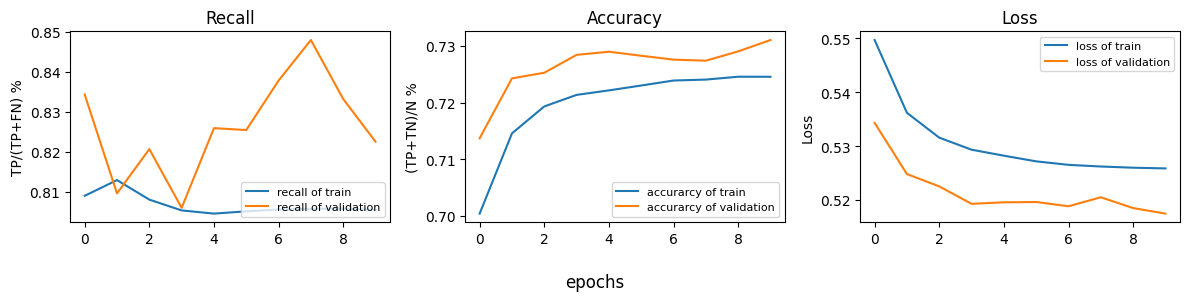

In [7]:
# evaluate model
c.plot_acc_recall()

20201/20201 ━━━━━━━━━━━━━━━━━━━━ 18s 915us/step - accuracy: 0.7307 - auc: 0.8089 - loss: 0.5176 - mse: 0.1763 - precision: 0.6987 - recall: 0.8239
{'accuracy': 0.7306883931159973, 'auc': 0.8088799715042114, 'loss': 0.5177138447761536, 'mse': 0.17627958953380585, 'precision': 0.6996412873268127, 'recall': 0.8226664662361145}
20201/20201 ━━━━━━━━━━━━━━━━━━━━ 8s 401us/step
[[0.3067872 ]
 [0.23948675]
 [0.8683479 ]]


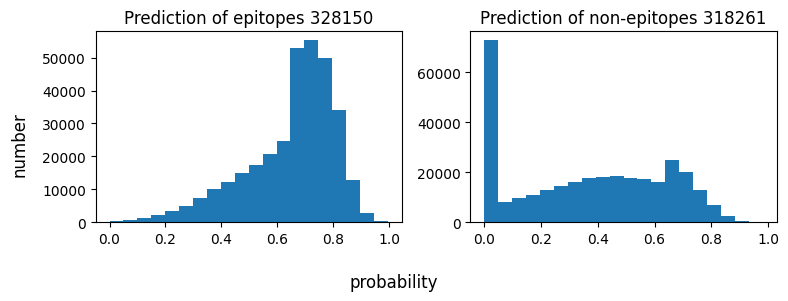

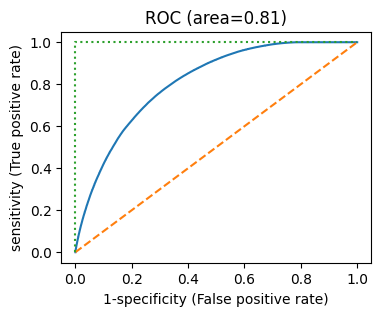

In [8]:
# evaluate model using test data
c.test()
c.plot_prob()
c.plot_roc()

In [9]:
# save entire model
c.save_model('../models/epitopes_ann_notCys.keras')

<Sequential name=sequential, built=True>

## filter II: having Cys

In [10]:
# keep epitopes container Cys
feature = 'has_C'
print('entire data:', df.shape)
print('epitopes without Cys:', df[(df[feature]==0) & (df['label']==1)].shape)
print('epitopes having Cys:', df[(df[feature]==1) & (df['label']==1)].shape)
sub_df = df[~((df[feature]==0) & (df['label']==1))]
print('filtered data:', sub_df.shape)

entire data: (3458238, 50)
epitopes without Cys: (1639058, 50)
epitopes having Cys: (226184, 50)
filtered data: (1819180, 50)


In [11]:
# prepare 
c = MyAnn()
c.get_xy(sub_df)

X: (1819180, 48) float16
y: (1819180,) float16
labels: Counter({np.float16(0.0): 1592996, np.float16(1.0): 226184})
train data: (1018740, 48) (1018740,)
validate data: (436604, 48) (436604,)
test data (363836, 48) (363836,)


In [12]:
# train model
c.declare_model()
c.train(epochs=10)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 512)            │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,433 (290.75 KB)

 Trainable params: 74,433 (290.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
31836/31836 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - accuracy: 0.9065 - auc: 0.9440 - loss: 0.1838 - mse: 0.0622 - precision: 0.6409 - recall: 0.5555 - val_accuracy: 0.9158 - val_auc: 0.9539 - val_loss: 0.1711 - val_mse: 0.0574 - val_precision: 0.6697 - val_recall: 0.6409
Epoch 2/10
31836/31836 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - accuracy: 0.9150 - auc: 0.9524 - loss: 0.1728 - mse: 0.0580 - precision: 0.6631 - recall: 0.6425 - val_accuracy: 0.9179 - val_auc: 0.9556 - val_loss: 0.1681 - val_mse: 0.0562 - val_precision: 0.6631 - val_recall: 0.6942
Epoch 3/10
31836/31836 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step - accuracy: 0.9170 - auc: 0.9537 - loss: 0.1705 - mse: 0.0570 - precision: 0.6602 - recall: 0.6799 - val_accuracy: 0.9184 - val_auc: 0.9564 - val_loss: 0.1668 - val_mse: 0.0556 - val_precision: 0.6593 - val_recall: 0.7148
Epoch 4/10
31836/31836 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step - accuracy: 0.9176 - auc: 0.9543 - loss: 0.1694 - mse: 0.0565 - precision: 0.6543 - recall: 0.7075 - 

,accuracy,auc,loss,mse,precision,recall,val_accuracy,val_auc,val_loss,val_mse,val_precision,val_recall
0,0.910484,0.948429,0.178315,0.060228,0.653019,0.594421,0.915830,0.953935,0.171123,0.057431,0.669719,0.640865
1,0.915397,0.952520,0.172444,0.057804,0.662279,0.649244,0.917903,0.955646,0.168150,0.056221,0.663058,0.694220
2,0.917141,0.953844,0.170372,0.056935,0.658921,0.688728,0.918395,0.956374,0.166776,0.055627,0.659289,0.714779
3,0.917813,0.954635,0.169169,0.056419,0.654716,0.714399,0.918952,0.957011,0.166915,0.055785,0.658277,0.727530
4,0.918463,0.955321,0.168179,0.056014,0.654638,0.725759,0.919343,0.957598,0.165335,0.055184,0.654966,0.745976
5,0.918719,0.955802,0.167385,0.055684,0.653973,0.732539,0.918965,0.957668,0.165047,0.055009,0.660337,0.720658
6,0.919057,0.956014,0.166961,0.055520,0.654396,0.736771,0.919900,0.958337,0.163811,0.054476,0.651986,0.766719
7,0.919663,0.956417,0.166392,0.055235,0.656611,0.739057,0.920399,0.958104,0.163342,0.054172,0.656128,0.759536
8,0.919805,0.956563,0.166259,0.055150,0.655827,0.744286,0.920317,0.958436,0.163389,0.054274,0.657897,0.751672
9,0.920073,0.956823,0.165761,0.054954,0.657194,0.743867,0.921265,0.958964,0.162448,0.053935,0.661247,0.755402


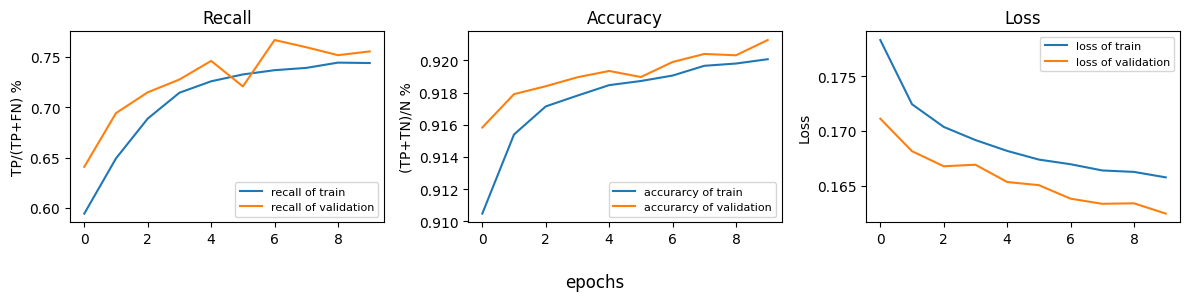

In [13]:
# evaluate model
c.plot_acc_recall()

11370/11370 ━━━━━━━━━━━━━━━━━━━━ 8s 742us/step - accuracy: 0.9229 - auc: 0.9592 - loss: 0.1613 - mse: 0.0534 - precision: 0.6634 - recall: 0.7623
{'accuracy': 0.9220857620239258, 'auc': 0.9592841863632202, 'loss': 0.1617615818977356, 'mse': 0.05370352789759636, 'precision': 0.6641308069229126, 'recall': 0.7584731578826904}
11370/11370 ━━━━━━━━━━━━━━━━━━━━ 4s 353us/step
[[0.]
 [0.]
 [0.]]


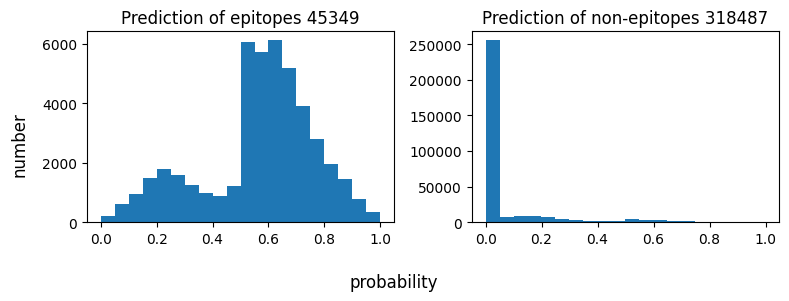

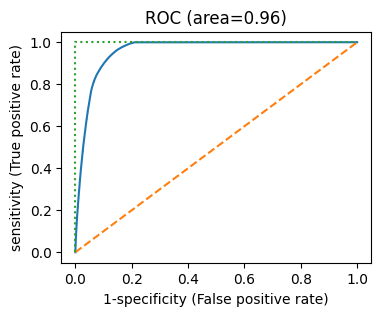

In [14]:
# evaluate model using test data
c.test()
c.plot_prob()
c.plot_roc()

In [15]:
# save entire model
c.save_model('../models/epitopes_ann_hasCys.keras')

<Sequential name=sequential_1, built=True>

## compare

In [21]:
model1 = tf.keras.models.load_model('../models/epitopes_ann_hasCys.keras')
model2 = tf.keras.models.load_model('../models/epitopes_ann_notCys.keras')

In [22]:
from seq.compare_model import CompareModel
cm = CompareModel(model1, model2)
cm.predict(df)

X: (3458238, 48) float16
y: (3458238,) float16
labels: Counter({np.float16(1.0): 1865242, np.float16(0.0): 1592996})
108070/108070 ━━━━━━━━━━━━━━━━━━━━ 51s 469us/step
108070/108070 ━━━━━━━━━━━━━━━━━━━━ 46s 427us/step


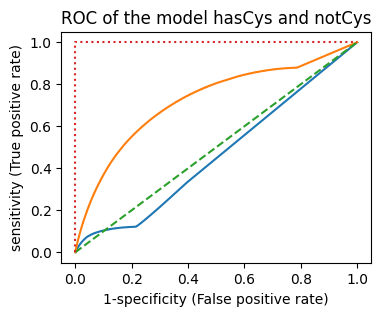

In [23]:
cm.plot_roc('hasCys', 'notCys')